#installing dependencies that we need

In [1]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

     |████████████████████████████████| 3.1 MB 9.7 MB/s 
     |████████████████████████████████| 596 kB 62.3 MB/s 
     |████████████████████████████████| 880 kB 52.6 MB/s 
     |████████████████████████████████| 3.3 MB 56.6 MB/s 
     |████████████████████████████████| 77 kB 7.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=30b82747e06e676ff03bcc1b122418b44fae79855b035cea9dcc0374820bec9d
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 126 kB 8.5 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 564, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 564 (delta 25), reused 22 (delta 22),

Let's download some Arabic text classification dataset to test the model on

In [2]:
!git clone https://github.com/elnagara/HARD-Arabic-Dataset

Cloning into 'HARD-Arabic-Dataset'...
remote: Enumerating objects: 100, done.
remote: Total 100 (delta 0), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (100/100), 116.36 MiB | 23.50 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Cloning into 'ASTD'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.
Cloning into 'AraSenti'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), done.
Cloning into 'LABR'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (37/37), done.
--2022-05-08 08:39:29--  http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
Resolving homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)... 129.215.32.113
Connecting to homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)|129.215.32.113|:80... connected.
HTT

#Creating training datasets

In [3]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [5]:
# specify columns names
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

You can choose which ever dataset you like or use your own.
At this stage we don't do any preprocessing on the text, this is done later when loading the text.



```
# This is formatted as code
```

##dataset 

In [35]:
df = pd.read_csv("/content/balanced-reviews.txt", sep="\t", header=0,encoding='utf-16')

df = df[["review","rating"]]  # we are interested in rating and review only

# Rename The columns name of data be text and label 
df.columns = [DATA_COLUMN, LABEL_COLUMN]

# know the labels counts
print(df[LABEL_COLUMN].value_counts())


# code rating as +ve if > 3, -ve if less, no 3s in dataset
hard_map = {
    5: 'POS',
    4: 'POS',
    2: 'NEG',
    1: 'NEG'
}

# apply the hard map convert the labels >3 to "POS" and < 3 to "NEG"
df[LABEL_COLUMN] = df[LABEL_COLUMN].apply(lambda x: hard_map[x])

# split the dataset into training and testing, the percentage of testing is 20%
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

label_list = ['NEG', 'POS']
label_map = {
    'NEG':0,
    'POS':1
}

# data = CustomDataset("HARD", train, test, label_list)

2    38467
4    26450
5    26399
1    14382
Name: label, dtype: int64


#Trainer

Start the training procedure

In [13]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy
from arabert.preprocess import ArabertPreprocessor
# some metrices to test the model performance
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [21]:
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects

Create and apply preprocessing using the AraBERT processor

In [20]:
arabic_prep = ArabertPreprocessor(model_name)

train_df[DATA_COLUMN] = train_df[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
test_df[DATA_COLUMN] =test_df[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))  

In [22]:
# Sanity check on the dataset
list(train_df[DATA_COLUMN][0:10])

['“ الفندق بحتاج لمتابعة كي لا يخسر الزبائن ” . موظف الاستقبال العربي كان مهذب و محترم هذا الموظف يستحق التقدير . لا توجد مواقف قريبة منهمعاملة موظف الاستقبال الفترة الصباحية سيئة وغير مهذب . لو اعرف رقم مدير الفندق بتصل فيه اشتكي على موظف الاستقبال',
 'جيد . طاقم الاستقبال وخدمة الغرف . الزحمه فى معظم الأوقات اذا اردت الذهاب إلى دبي او الى داخل المدينه',
 'استثنائي . الافطار كان لذيذا . المرتبة غير مريحة و تحتاج الي تغير',
 'ضعيف . . المبلغ ليس مقابل الخدمه',
 'جيد جدا . قربة من الامارات مول . الفطور عادي جداوجود حفريات ويصعب وقوف التاكسي',
 'مخيب للأمل . . عمال التنظيف ليسوا علي مستوي الكفاءة والأمانة',
 'مخيب للأمل . لا يوجد . العرض غير الواقع',
 '“ تجربة جديدة . مريح . طاقم بشوش ومتعاون ” . الفطور جيد وتعامل الموظفين راقي وموقع الفندق مناسب و للأطفال جدا مناسب .',
 '“ كانت رائعه ” . الرائحة العطره وإحضار سرير للبيبي .',
 'استثنائي . فندق رائع .']

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [23]:
tok = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/733k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Sentence Lengths: 


Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors


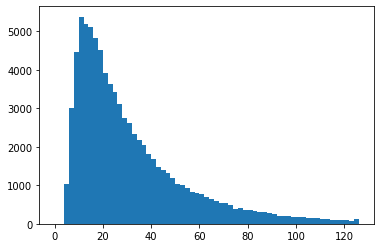

Testing Sentence Lengths: 


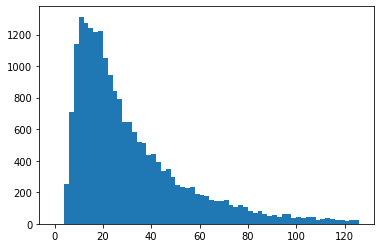

In [24]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in train_df[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in test_df[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

Let's select 128 as our maximum sentence length, and check how many sequences will be truncated

In [39]:
max_len = 128

In [40]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in train_df[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in test_df[DATA_COLUMN].to_list()]))

Truncated training sequences:  1821
Truncated testing sequences:  455


Now let's create a classification dataset to load the data

In [41]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
        
      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )      
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [42]:
train_dataset = ClassificationDataset(
    train_df[DATA_COLUMN].to_list(),
    train_df[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    test_df[DATA_COLUMN].to_list(),
    test_df[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
   label_map
  )

Check the dataset output

In [43]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 174, 11219, 19487, 562, 8237, 2809, 391, 15284, 15871, 175, 20, 5047, 11735, 1254, 418, 1746, 2552, 139, 37216, 434, 3652, 6655, 13423, 20, 391, 4274, 4684, 9376, 1900, 2817, 197, 5047, 11735, 1522, 17168, 11712, 1562, 1746, 2552, 20, 1422, 17026, 2245, 1075, 11219, 7637, 182, 903, 2537, 612, 323, 5047, 11735, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0,

Create a function that return a pretrained model ready to do classification

In [44]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Define whatever metric you want here

In [45]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  #macro_precision = precision_score(p.label_ids,preds,average='macro')
  #macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
  }

In [46]:
# seed is set to keep the result the same in every time you run the model
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

#Regular Training

Define our training parameters.
Check the TrainingArguments documentation for more options https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [48]:
#the parameters for training the model, you can change what you want for example the no of epochs or the learning rate to acheive the highest performance
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

Create the trainer

In [49]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/667 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [50]:
#start the training
trainer.train()

***** Running training *****
  Num examples = 84558
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5284


KeyboardInterrupt: ignored

Save the model, the tokenizer and the config

In [51]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir/config.json


{0: 'NEG', 1: 'POS'}


Model weights saved in output_dir/pytorch_model.bin
tokenizer config file saved in output_dir/tokenizer_config.json
Special tokens file saved in output_dir/special_tokens_map.json


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

## predict using the saved model

In [ ]:
from transformers import pipeline

In [ ]:
# initialize pipline
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=True)

In [ ]:
pipe("لقد حضرت الفيلم وكان رائع جدا ")